In [1]:
# READ IN DATA

import pandas as pd

df = pd.read_csv('dataset_lstm.csv')[['index', 'FEN', 'label']]

# df = df[df['index'] < 1000]
# df['index'] = df['index'] + df['label'] * 1000
df

,index,FEN,label
0,0,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,0
1,0,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,0
2,0,rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBN...,0
3,0,rnbqkbnr/pp2pppp/2p5/3p4/2PP4/8/PP2PPPP/RNBQKB...,0
4,0,rnbqkbnr/pp2pppp/2p5/3p4/2PP4/4P3/PP3PPP/RNBQK...,0
...,...,...,...
136300,1999,b5k1/5pb1/p7/2p3p1/2P3Q1/6P1/P1KP1PqP/1r6 w - ...,1
136301,1999,b5k1/5pb1/p7/2p3p1/2P3Q1/6P1/P2P1PqP/1K6 b - -...,1
136302,1999,b5k1/5pb1/p7/2p3p1/2P1q1Q1/6P1/P2P1P1P/1K6 w -...,1
136303,1999,b5k1/5pb1/p7/2p3p1/2P1q1Q1/3P2P1/P4P1P/1K6 b -...,1


In [2]:
df['FEN'][1]

'rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2'

In [3]:
# ADD COLUMN "NEXT_FEN" WHICH REPRESENTS STATE OF THE BOARD IN STATE = T+1

import numpy as np

def next_fens(data):
    next_FEN = []
    for i, index in enumerate(data['index']):
        if len(data['index']) == i+1:
            next_FEN.append(np.nan)
        elif index != data['index'][i+1]:
            next_FEN.append(np.nan)
        else:
            next_FEN.append(data['FEN'][i+1])
    return next_FEN

df['next_FEN'] = next_fens(df)

In [4]:
df.dropna(inplace=True)

In [5]:
import torch
from torch import nn

from model_lstm import CheaterClassifier

# device = torch.device('cuda')
model = CheaterClassifier()
# model.to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)

In [6]:
piece_to_token   = {'r' :        1,
                   'n' :        2,
                   'b' :        3,
                   'q' :        4,
                   'k' :        5,
                   'p' :        6,
                   'R' :        7,
                   'N' :        8,
                   'B' :        9,
                   'Q' :        10,
                   'K' :        11,
                   'P' :        12,
                   'empty' :    0}

def fen_to_network_input_tokenized(fen):
    encoded_board = []
    fen = fen.split()[0]
    for char in fen:
        if char in piece_to_token.keys():
            encoded_board.append(piece_to_token[char])
        elif char != '/':
            for _ in range(int(char)):
                encoded_board.append(piece_to_token['empty'])
    return encoded_board

In [7]:
df['FEN_tokenized'] = df['FEN'].apply(fen_to_network_input_tokenized)
df['next_FEN_tokenized'] = df['next_FEN'].apply(fen_to_network_input_tokenized)
df['input'] = df['FEN_tokenized'] + df['next_FEN_tokenized']
len(df['input'][0])

128

In [8]:
df[df['label']==1]['input']

68017     [1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...
68018     [1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...
68019     [1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 6, 6, 6, 6, ...
68020     [1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 6, 6, 6, 6, ...
68021     [1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 6, 0, 6, 6, ...
                                ...                        
136299    [3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 3, ...
136300    [3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 3, ...
136301    [3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 3, ...
136302    [3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 3, ...
136303    [3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 3, ...
Name: input, Length: 67288, dtype: object

In [9]:
shuffled_game_indexes = df['index'].drop_duplicates().sample(frac=1).values

In [10]:
train_size = int(.99 * len(shuffled_game_indexes))

In [11]:
# SELECT GAME INDEXES FOR TRAIN AND TEST DATA SETS

train_indexes = shuffled_game_indexes[:train_size]
test_indexes = shuffled_game_indexes[train_size:]

In [12]:
# TRAIN MODEL

from tqdm import tqdm
from collections import deque
import numpy as np

EPOCHS = 1
patience = 50
loss_buffer = deque(maxlen=patience)
loss_buffer.append(10000000000)
patience_check = 0

loss_list = []

val_loss_list = []

for epoch in tqdm(range(1,EPOCHS+1)):
    model.train()
    loss_sum = 0
    for i, idx in enumerate(train_indexes):
        inputs  = [input for input in df[df['index']==idx]['input'].values]
        labels = df[df['index']==idx]['label'].values
        inputs = torch.tensor(inputs,dtype=torch.int)
        labels = torch.tensor(labels,dtype=torch.float32)
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.unsqueeze(1)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        loss_sum += loss
    
    loss_avg = loss_sum / (i + 1)

    loss_list.append(loss_avg)

    model.eval()
    val_loss_sum = 0
    for j, idx in enumerate(test_indexes):
        val_inputs  = [input for input in df[df['index']==idx]['input'].values]
        val_labels = df[df['index']==idx]['label'].values
        val_inputs = torch.tensor(val_inputs,dtype=torch.int)
        val_labels = torch.tensor(val_labels,dtype=torch.float32)
        with torch.no_grad():
            val_outputs = model(val_inputs)
        val_labels = val_labels.unsqueeze(1)
        val_loss = loss_fn(val_outputs, val_labels)
        val_loss_sum += val_loss

    val_loss_avg = val_loss_sum / (j + 1)

    val_loss_list.append(val_loss_avg)


    print(f'EPOCH: {epoch}; avg_loss {loss_avg}; avg_val_loss {val_loss_avg}; lowest val_loss in last {patience} epochs: {np.min(loss_buffer)}')

    if val_loss_avg > np.min(loss_buffer) and patience_check > patience:
        break
    elif val_loss_avg < np.min(loss_buffer):
        patience_check = 0
        print('###MODEL CHECKPOINT###')
        torch.save(model.state_dict(), 'checkpoint_full_games.pt')
    else:
        patience_check += 1

    loss_buffer.append(val_loss_avg)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:21<00:00, 21.55s/it]

EPOCH: 1; avg_loss 0.6850805878639221; avg_val_loss 0.6606855988502502; lowest val_loss in last 50 epochs: 10000000000
###MODEL CHECKPOINT###


In [13]:

print(df[df['label']==0]['label'].iloc[0])
print(df[df['label']==1]['label'].iloc[0])

0
1


In [14]:
model.eval()
model(torch.tensor(df[df['label']==1]['input'].iloc[6],dtype=torch.int).unsqueeze(0))

tensor([[0.5151]], grad_fn=<SigmoidBackward0>)

In [15]:
# model.load_state_dict(torch.load('checkpoint_full_games.pt'))

<All keys matched successfully>

In [16]:
import numpy as np

inputs = []
predictions = []
targets = []
logits = []
new_labels = []
model.eval()


for j, idx in enumerate(test_indexes):
    val_inputs  = [input for input in df[df['index']==idx]['input'].values]
    val_labels = df[df['index']==idx]['label'].values
    val_inputs = torch.tensor(val_inputs,dtype=torch.int)
    val_labels = torch.tensor(val_labels,dtype=torch.float32)
# for i, val_data in enumerate(data_test):
#     val_inputs, val_labels = val_data
    inputs.append(val_inputs)
    outputs = model(val_inputs)
    outputs = outputs.detach().numpy()
    targets.append(np.vstack(val_labels.numpy()))
    predictions.append(outputs.round())
    logits.append(outputs)
    outputs = [1 if output >= .5 else 0 for output in outputs]
    # outputs = [0 if output <= .3 else 2 for output in outputs]
    new_labels.append(np.vstack(np.array(outputs)))
    # predictions.append(np.vstack(np.array([0 if output <= .2 else 0.5 for output in [1 if output >= .8 else output for output in outputs]])))

inputs = np.vstack(inputs)
predictions = np.vstack(predictions)
targets = np.vstack(targets)
logits = np.vstack(logits)
new_labels = np.vstack(new_labels)

In [17]:
len(targets)

1321

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

print(confusion_matrix(targets, predictions))
print(accuracy_score(targets, predictions))
print(f1_score(targets, predictions))
print(roc_auc_score(targets,logits))
fpr, tpr, thresholds = roc_curve(targets,logits)

[[770 143]
 [ 54 354]]
0.8508705526116578
0.7823204419889503
0.9139069647574255


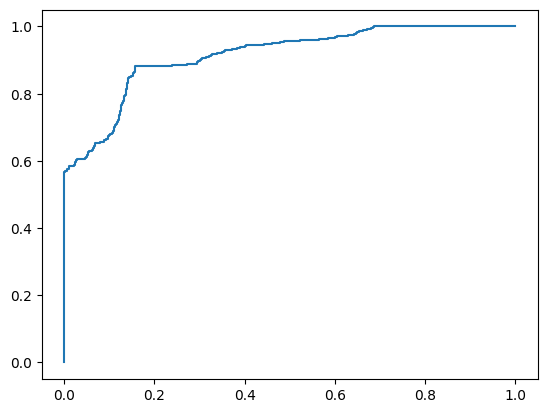

In [19]:
from matplotlib import pyplot as plt

plt.plot(fpr, tpr)

In [70]:
# torch.save(model.state_dict(), 'best_model.pt')